In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

import umap
import hdbscan
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from keras.layers import Dense, Input
from keras.models import Model
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

In [4]:
df['ui_area'] = df['ui_area'].map(get_coded_str)

In [5]:
df.head(5)

,user_id,ui_area,times_viewed,time_spent
0,3398969716,8VWZUV,108,296636
1,3398969716,78HNVT,24,1543
2,3398969716,YB4CO1,70,11454
3,3398969716,YRAEMF,22,96665
4,3398969716,HOW0B3,24,250


In [6]:
df_pivot = \
    pd.pivot_table(df, index='user_id', columns='ui_area', values='time_spent', fill_value=0)

In [7]:
def normalize_df(_df):
    return _df / _df.values.max(axis=1).reshape(-1, 1)
    # we can do the same with sum()
    # or with  _df.values / _df.values.max(axis=1)[:, np.newaxis]

df_norm = normalize_df(df_pivot) 

In [8]:
df_norm.head(10)

ui_area,08Q4AO,0NSTLT,0PUBVE,1NTBU6,2LY7G9,380GNH,3GRXCC,4EREE0,67ROPV,6U8M0D,...,SYW6AT,U1EYI1,UA5X5I,V7OBIK,VGRMHI,X2C9QR,Y7LRIO,YB4CO1,YRAEMF,ZCU8G6
user_id,,,,,,,,,,,,,,,,,,,,,
80000011,0.000189,0.016664,1.000000,0.000000,0.000000,0.010629,0.000000,0.000048,0.000057,0.000000,...,0.000093,0.000043,0.003044,0.000000,0.000202,0.000597,0.000000,0.000012,0.013974,0.000067
80000062,0.000000,0.004319,1.000000,0.000000,0.000000,0.009070,0.000000,0.000584,0.000000,0.000000,...,0.000000,0.000000,0.018347,0.000055,0.000000,0.000146,0.000000,0.000000,0.205924,0.000000
80000063,0.000422,0.019130,0.160967,0.000000,0.000000,0.000590,0.000084,0.000000,0.000464,0.000000,...,0.000000,0.000000,0.000478,0.000365,0.000000,0.000337,0.000000,0.225905,0.000520,0.000000
80000094,0.000000,0.000354,1.000000,0.000000,0.000000,0.000000,0.000000,0.000885,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000024,0.000000,0.000024,0.000000,0.000000,0.000000,0.000000
80000099,0.000000,0.011001,0.000000,0.000000,0.000019,0.374122,0.157078,0.000000,0.000052,0.000000,...,0.000000,0.000000,0.000886,0.000017,1.000000,0.000000,0.000000,0.000000,0.255548,0.000000
80000118,0.002599,0.000000,1.000000,0.000000,0.007560,0.000007,0.000034,0.010513,0.000005,0.000000,...,0.000000,0.025757,0.000012,0.000003,0.000000,0.000019,0.000000,0.534339,0.021662,0.000140
80000138,0.000174,0.015288,1.000000,0.000000,0.000000,0.300849,0.000000,0.040534,0.036955,0.000000,...,0.000000,0.000364,0.036575,0.000000,0.000000,0.000058,0.000000,0.125022,0.887944,0.000347
80000150,0.000000,0.000000,0.000627,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000052,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
80000164,0.000357,0.065594,0.658962,0.000796,0.000091,0.029783,0.000052,0.000610,0.215039,0.111881,...,0.000195,0.005460,0.147992,0.000124,0.000067,0.067109,0.000648,0.019068,0.107060,0.000572


In [9]:
def get_autoencoder(dims, act='relu'):
    n_stacks = len(dims) - 1
    x = Input(shape=(dims[0],), name='input')

    h = x
    for i in range(n_stacks - 1):
        h = Dense(dims[i + 1], activation=act, name='encoder_%d' % i)(h)

    h = Dense(dims[-1], name='encoder_%d' % (n_stacks - 1))(h)
    for i in range(n_stacks - 1, 0, -1):
        h = Dense(dims[i], activation=act, name='decoder_%d' % i)(h)

    h = Dense(dims[0], name='decoder_0')(h)

    model = Model(inputs=x, outputs=h)
    model.summary()
    return model

In [10]:
def learn_manifold(x_data, umap_min_dist=0.00, umap_metric='euclidean', umap_dim=10, umap_neighbors=30):
    md = float(umap_min_dist)
    return umap.UMAP(
        random_state=0,
        metric=umap_metric,
        n_components=umap_dim,
        n_neighbors=umap_neighbors,
        min_dist=md).fit_transform(x_data)

In [11]:
X = df_norm.values
X_train, X_test = train_test_split(X, test_size=0.2, random_state=11)

In [12]:
batch_size = 256
pretrain_epochs = 64
encoded_dimensions = 10
shape = [X.shape[-1], 250, 250, 500, encoded_dimensions]

print(shape)

autoencoder = get_autoencoder(shape)

[50, 250, 250, 500, 10]
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 50)]              0         
_________________________________________________________________
encoder_0 (Dense)            (None, 250)               12750     
_________________________________________________________________
encoder_1 (Dense)            (None, 250)               62750     
_________________________________________________________________
encoder_2 (Dense)            (None, 500)               125500    
_________________________________________________________________
encoder_3 (Dense)            (None, 10)                5010      
_________________________________________________________________
decoder_3 (Dense)            (None, 500)               5500      
_________________________________________________________________
decoder_2 (Dense)            (

In [13]:
encoded_layer = f'encoder_{(len(shape) - 2)}'

print(f'taking the last encoder layer:{encoded_layer}')

hidden_encoder_layer = autoencoder.get_layer(name=encoded_layer).output
encoder = Model(inputs=autoencoder.input, outputs=hidden_encoder_layer)
autoencoder.compile(loss='mse', optimizer='adam')

taking the last encoder layer:encoder_3


In [20]:
#train the autoencoder
model_series = 'CLS_MODEL_' + datetime.now().strftime("%h%d%Y-%H%M")

checkpointer = ModelCheckpoint(filepath=f"{model_series}-model.h5", verbose=0, save_best_only=True)

autoencoder.fit(
    X_train,
    X_train,
    batch_size=batch_size,
    epochs=pretrain_epochs,
    verbose=1,
    validation_data=(X_test, X_test),
    callbacks=[checkpointer]
)

autoencoder = load_model(f"{model_series}-model.h5")

Epoch 1/64
104/104 [==============================] - 1s 7ms/step - loss: 0.0141 - val_loss: 0.0075
Epoch 2/64
104/104 [==============================] - 1s 5ms/step - loss: 0.0059 - val_loss: 0.0051
Epoch 3/64
104/104 [==============================] - 1s 5ms/step - loss: 0.0046 - val_loss: 0.0045
Epoch 4/64
104/104 [==============================] - 1s 5ms/step - loss: 0.0041 - val_loss: 0.0041
Epoch 5/64
104/104 [==============================] - 1s 5ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 6/64
104/104 [==============================] - 1s 5ms/step - loss: 0.0035 - val_loss: 0.0037
Epoch 7/64
104/104 [==============================] - 1s 5ms/step - loss: 0.0033 - val_loss: 0.0035
Epoch 8/64
104/104 [==============================] - 1s 5ms/step - loss: 0.0032 - val_loss: 0.0035
Epoch 9/64
104/104 [==============================] - 1s 5ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 10/64
104/104 [==============================] - 1s 5ms/step - loss: 0.0029 - val_loss: 0.0032

In [21]:
# save its weights
weights_name = 'weights/' + model_series + "-" + str(pretrain_epochs) + '-ae_weights.h5'
autoencoder.save_weights(weights_name)

In [22]:
# use the weights learned by the encoder to encode the data to a representation (embedding)
X_encoded = encoder.predict(X)

In [23]:
X_reduced = learn_manifold(X_encoded, umap_neighbors=30, umap_dim=int(encoded_dimensions/2))

In [25]:
# this is the data that we need to cluster
labels = hdbscan.HDBSCAN(
    min_samples=100,
    min_cluster_size=1000,
).fit_predict(X_reduced)

In [26]:
unique, counts = np.unique(labels, return_counts=True)
print (np.asarray((unique, counts)).T)

[[   -1    20]
 [    0  5016]
 [    1  1767]
 [    2  8694]
 [    3 17601]]


In [27]:
#important to note that the clustering was performed on the result of UMAP
# but the 2 dim lowering here (in order to generate the plot - was performed on the result of the encoder only)
reducer = umap.UMAP(n_components=2)
embedding = reducer.fit_transform(X_encoded)

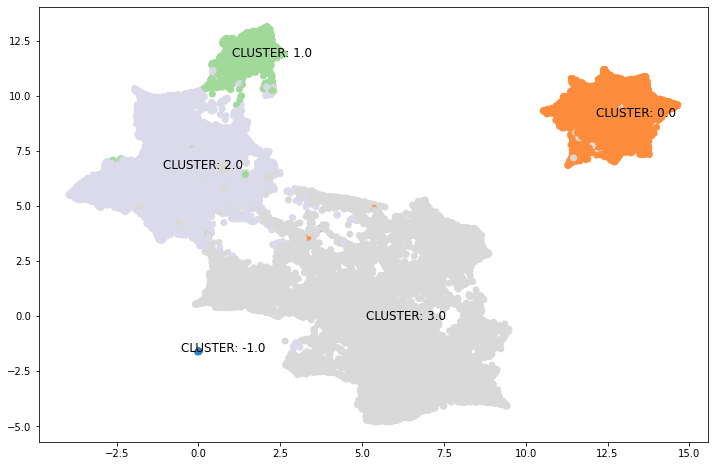

In [28]:
fig = plt.figure(figsize=(12,8))
plt.scatter(reducer.embedding_[:, 0], reducer.embedding_[:, 1], c=labels, cmap='tab20c')

viz_clusters = pd.DataFrame(embedding)
viz_clusters['cluster'] = labels

for row in viz_clusters.groupby('cluster').mean().reset_index().values:
    label = f'CLUSTER: {row[0]}'
    plt.annotate(label, (row[1], row[2]), textcoords="offset points", fontsize=12,  xytext=(25,0), ha='center') 